<h1> SOTA: BERT Based STS scores </h1>
<p>The pretrained SBERT embeddings which are fine tuned on STS dataset are used for generating sentence embeddings.</p>

In [4]:
import pandas as pd
import numpy as np

In [5]:
train_df = pd.read_csv('../data/cleaned_train_df.csv')
val_df = pd.read_csv('../data/cleaned_val_df.csv')
test_df = pd.read_csv('../data/cleaned_test_df.csv')

In [6]:
train_df['sent1'] = train_df['sent1'].apply(eval)
train_df['sent2'] = train_df['sent2'].apply(eval)

In [7]:
val_df['sent1'] = val_df['sent1'].apply(eval)
val_df['sent2'] = val_df['sent2'].apply(eval)

In [8]:
test_df['sent1'] = test_df['sent1'].apply(eval)
test_df['sent2'] = test_df['sent2'].apply(eval)

In [9]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

In [10]:
train_embeddings1 = list(train_df['sent1'])
train_embeddings2 = list(train_df['sent2'])

In [11]:
train_embeddings1 = [" ".join(i for i in j) for j in train_embeddings1]
train_embeddings2 = [" ".join(i for i in j) for j in train_embeddings2]

In [12]:
train_embeddings1 = model.encode(train_embeddings1)
train_embeddings2 = model.encode(train_embeddings2)

In [13]:
train_embeddings1.shape, train_embeddings2.shape

((5749, 768), (5749, 768))

In [14]:
y_train = list(train_df["score"])

In [23]:
def sts_score(sim_score):
    sts_score = (sim_score+1) * 2.5
    return sts_score

In [30]:
from scipy import spatial
from scipy.stats import pearsonr

def get_sts_scores(emb1_lt, emb2_lt):
    y_pred = []
    for i in range(len(emb1_lt)):
        sim_score = 1 - spatial.distance.cosine(emb1_lt[i], emb2_lt[i])
        y_pred.append(sts_score(sim_score))
    return y_pred
    
def pearson_corr(y_true, y_pred):
    """
    Calculate Pearson correlation coefficient between two arrays.
    """
    corr, _ = pearsonr(y_true, y_pred)
    return corr

In [31]:
y_pred = get_sts_scores(train_embeddings1, train_embeddings2)

In [32]:
# Calculate Pearson correlation coefficient between predicted values and target values
corr = pearson_corr(y_train, y_pred)

# Print the correlation coefficient
print("Pearson correlation coefficient: {:.2f}".format(corr))

Pearson correlation coefficient: 0.87


In [33]:
val_embeddings1 = list(val_df['sent1'])
val_embeddings2 = list(val_df['sent2'])

In [34]:
val_embeddings1 = [" ".join(i for i in j) for j in val_embeddings1]
val_embeddings2 = [" ".join(i for i in j) for j in val_embeddings2]

In [35]:
val_embeddings1 = model.encode(val_embeddings1)
val_embeddings2 = model.encode(val_embeddings2)

In [36]:
y_val = list(val_df["score"])

In [37]:
y_pred = get_sts_scores(val_embeddings1, val_embeddings2)

In [38]:
# Calculate Pearson correlation coefficient between predicted values and target values
corr = pearson_corr(y_val, y_pred)

# Print the correlation coefficient
print("Pearson correlation coefficient: {:.2f}".format(corr))

Pearson correlation coefficient: 0.79


In [65]:
test_embeddings1 = list(test_df['sent1'])
test_embeddings2 = list(test_df['sent2'])

In [40]:
test_embeddings1 = [" ".join(i for i in j) for j in test_embeddings1]
test_embeddings2 = [" ".join(i for i in j) for j in test_embeddings2]

In [41]:
test_embeddings1 = model.encode(test_embeddings1)
test_embeddings2 = model.encode(test_embeddings2)

In [42]:
y_test = list(test_df["score"])

In [43]:
y_pred = get_sts_scores(test_embeddings1, test_embeddings2)

In [44]:
# Calculate Pearson correlation coefficient between predicted values and target values
corr = pearson_corr(y_test, y_pred)

# Print the correlation coefficient
print("Pearson correlation coefficient: {:.2f}".format(corr))

Pearson correlation coefficient: 0.76


In [74]:
test_emb1 = model.encode("boy came to college")
test_emb2 = model.encode("boy came from college")

In [75]:
test_emb1.shape

(768,)

In [76]:
sim_score = 1 - spatial.distance.cosine(test_emb1, test_emb2)

In [77]:
sts_score(sim_score)

4.7033630311489105

In [46]:
row_max_len = lambda row: max(len(row['sent1']), len(row['sent2']))

In [47]:
train_df['sent_len'] = train_df.apply(row_max_len, axis=1)

In [48]:
val_df['sent_len'] = val_df.apply(row_max_len, axis=1)

In [49]:
test_df['sent_len'] = test_df.apply(row_max_len, axis=1)

In [51]:
test_df['diff'] = abs(test_df['score'] - y_pred)

In [52]:
grouped_test = test_df.groupby(['sent_len']).mean()

/var/folders/gb/8lc9v2sx5mq19kgysgv67bzw0000gn/T/ipykernel_43417/1156243688.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_test = test_df.groupby(['sent_len']).mean()


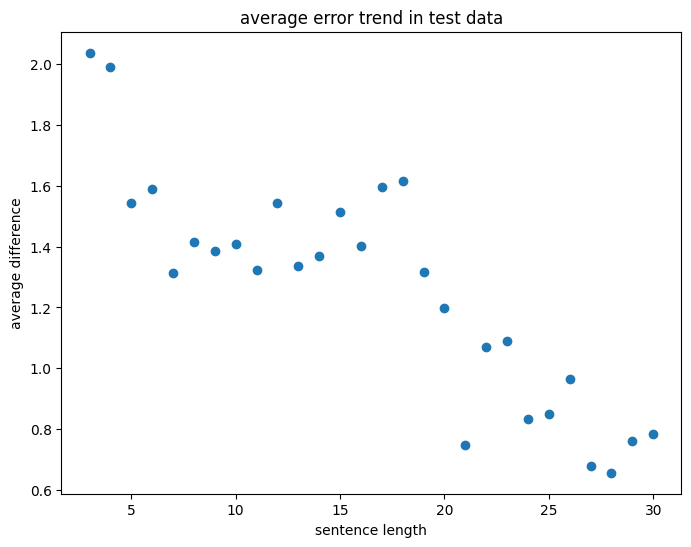

In [53]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(list(grouped_test.index), list(grouped_test['diff']))
plt.title("average error trend in test data")
plt.xlabel("sentence length")
plt.ylabel("average difference")
plt.show()